<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

#  Analyzing Ring Diffraction Pattern
[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_05-Diffraction_Rings.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2022.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade https://github.com/pycroscopy/pyTEMlib/tarball/master
print('done')

done


### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [5]:
%pylab --no-import-all notebook
    
# 3D plotting package 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting

# additional package 
import  itertools 
import scipy.constants as const
import os

# Import libraries from the book
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book
import pyTEMlib.file_tools as ft     
# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2022.01.20'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2022.1.0
notebook version:  2022.01.20



## Load Ring-Diffraction Pattern
### First we select the diffraction pattern

Load the **GOLD-NP-DIFF.dm3** file as an example.
  
The dynamic range of diffraction patterns is too high for computer screens and so we take the logarithm of the intensity. 

Cannot overwrite file. Using:  GOLD_NP_DIFF-1.hf5


C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


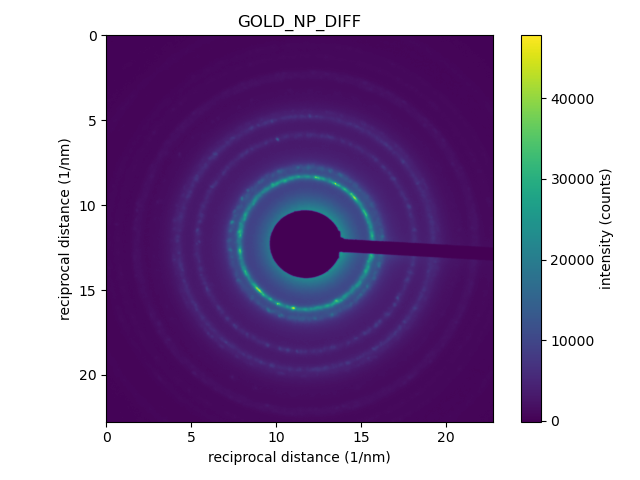

In [7]:
# ------Input -------------
load_your_own_data = False
# -------------------------

try:
    # close any open files before open new one
    main_dataset.h5_dataset.file.close()
except:
    pass
if load_your_own_data:
    main_dataset = ft.open_file()
else:  # load example
    main_dataset = ft.open_file(os.path.join("../example_data", "GOLD-NP-DIFF.dm3"))
view = main_dataset.plot()

## Finding the center

### First try with cross correlation of rotated images

### Cross- and Auto- Correlation
    
Cross correlation and auto correlation are based on a  multiplication in Fourier space. In the case of a an auto-correlation it is the same data while in the cross correlation it is another data (here the transposed (rotated) diffraction pattern)"

<IPython.core.display.Javascript object>


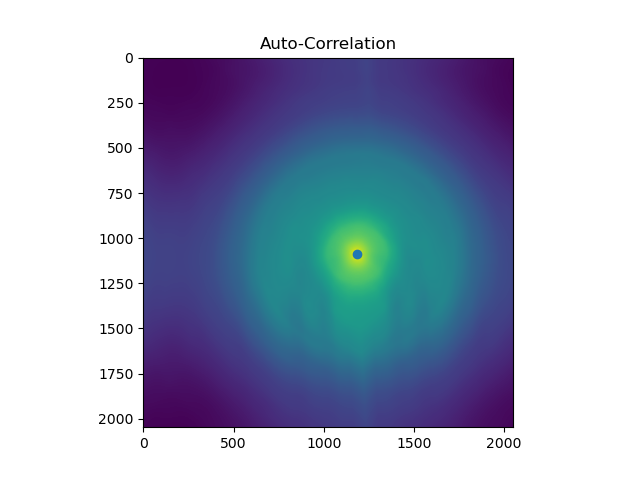

center = (1090, 1182) which is a shift of 66.0 px in x and 158.0 px in y direction


In [8]:
## Access the data of the loaded image
    
diff_pattern = np.array(main_dataset)
diff_pattern = diff_pattern-diff_pattern.min()
correlation = 'auto'
dif_ft = np.fft.fft2(diff_pattern)
if correlation == 'auto':
    auto_correlation  = np.fft.fftshift(np.fft.ifft2(dif_ft*dif_ft))
    center = np.unravel_index(np.argmax(auto_correlation.real, axis=None), auto_correlation.real.shape)
    plt.figure()
    plt.title('Auto-Correlation')
    plt.imshow(auto_correlation.real);
else:   
    dif_ft2 = np.fft.fft2(diff_pattern.T)
    cross_correlation  = np.fft.fftshift(np.fft.ifft2(dif_ft*dif_ft2))
    center = np.unravel_index(np.argmax(cross_correlation.real, axis=None), cross_correlation.real.shape)
    plt.figure()
    plt.title('Cross-Correlation')
    plt.imshow(auto_correlation.real);

shift = np.array(center - np.array(dif_ft.shape)/2)
print(f'center = {center} which is a shift of {shift[0]} px in x and {shift[1]} px in y direction')
plt.scatter([center[1]],[center[0]]);

### How well did we do?

### Select the center yourself

The beam stop confuses the cross correlation sometimes and then we need to  adjust the selection

[-367.60687229 -286.70643939]


<IPython.core.display.Javascript object>


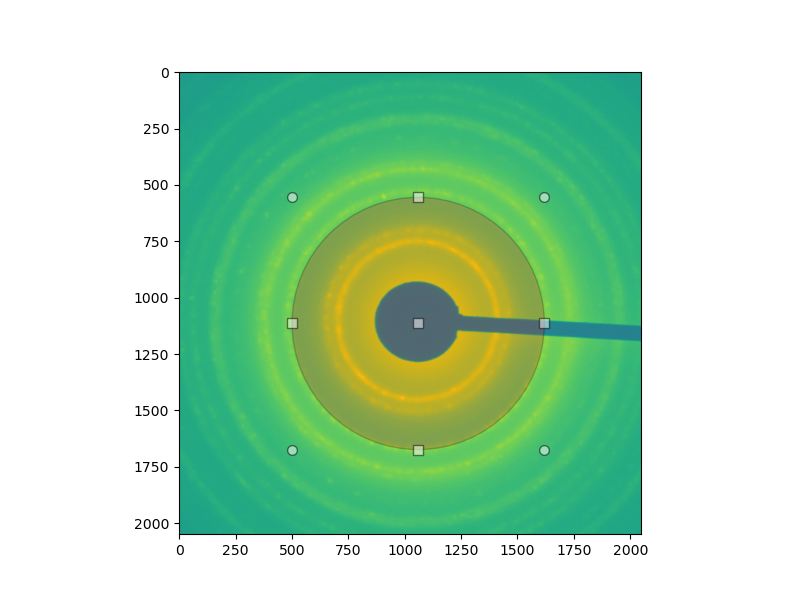

In [11]:
from matplotlib.widgets import  EllipseSelector
    
print(np.array(center)-2048)
center = np.array(center)

plt.figure(figsize=(8, 6))
plt.imshow(np.log(1.+diff_pattern).T, origin = 'upper')
selector = EllipseSelector(plt.gca(), None,interactive=True , drawtype='box')  # gca get current axis (plot)

selector.to_draw.set_visible(True)
radius = 559 
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)

Get center coordinates from selection

In [12]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'new center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius = 559 pixels
new center = (1059.7870670995676, 1114.0900974025974) [pixels]


## Ploting Diffraction Pattern in Polar Coordinates\n",

### The Transformation Routine

In [13]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff,center):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]

    x = np.linspace(1, nx, nx, endpoint = True)-center[0]
    y = np.linspace(1, ny, ny, endpoint = True)-center[1]
    z = diff

    # Define new polar grid
    nr = int(min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1)
    print(nr)
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x,y, z, r, t, order=3).T

### Now we transform

If the center is correct a ring in carthesian coordinates is a line in polar coordinates

A simple sum over all angles gives us then the diffraction profile (intensity profile of diffraction pattern)


932


<IPython.core.display.Javascript object>


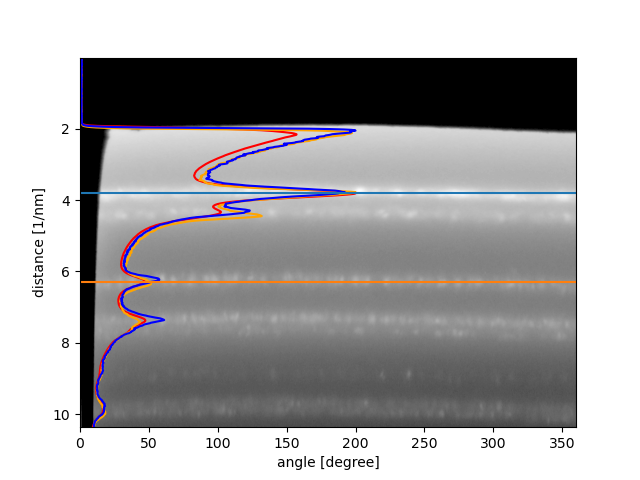

In [14]:
center = np.array(center)
out_tags={'center': center}
#center[1] = 1057
# center[0]= 1103
# center[1]=1055

polar_projection = warp(diff_pattern,center)
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

out_tags['polar_projection'] = polar_projection

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)
profile_0 = polar_projection[:,0:20].sum(axis=1)
profile_360 = polar_projection[:,340:360].sum(axis=1)
profile_180 = polar_projection[:,190:210].sum(axis=1)

profile_90 = polar_projection[:,80:100].sum(axis=1)
profile_270 = polar_projection[:,260:280].sum(axis=1)


out_tags['radial_average'] = profile

scale = ft.get_slope(main_dataset.dim_0.values)

plt.figure()
plt.imshow(np.log2(1+polar_projection),extent=(0,360,polar_projection.shape[0]*scale,scale),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)
ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(profile/profile.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='r');
#plt.plot(profile_0/profile_0.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='orange');
#plt.plot(profile_360/profile_360.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='orange');
#plt.plot(profile_180/profile_180.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='b');
plt.plot(profile_90/profile_90.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='orange');
plt.plot(profile_270/profile_270.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='b');


plt.plot([0,360],[3.8,3.8])
plt.plot([0,360],[6.3,6.3])

## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

[ 0.38161311  1.28476412  2.45504432  4.35038941  4.94824994  7.16160596
  8.42092921 11.2830275 ]


<IPython.core.display.Javascript object>


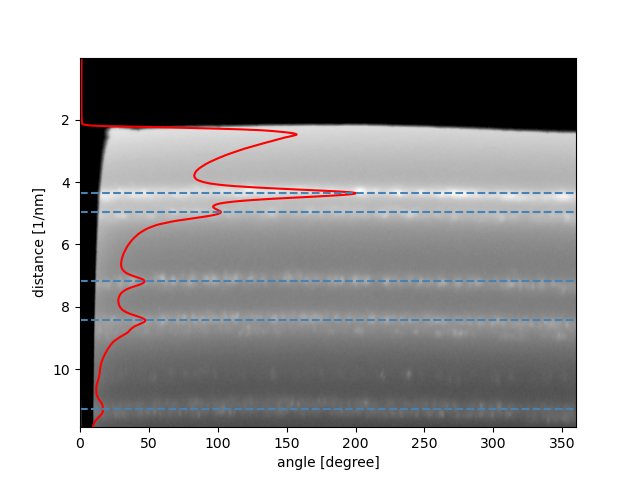

In [15]:
import scipy as sp
import scipy.signal as signal

scale = ft.get_slope(main_dataset.dim_0.values)*4.28/3.75901247*1.005
# find_Bragg peaks in profile
peaks, g= signal.find_peaks(profile,rel_height =0.7, width=7)  # np.std(second_deriv)*9)

print(peaks*scale)

out_tags['ring_radii_px'] = peaks


plt.figure()

plt.imshow(np.log2(1.+polar_projection),extent=(0,360,polar_projection.shape[0]*scale,scale),cmap='gray', vmin=np.max(np.log2(1+diff_pattern))*0.5)

ax = plt.gca()
ax.set_aspect("auto");
plt.xlabel('angle [degree]');
plt.ylabel('distance [1/nm]')

plt.plot(profile/profile.max()*200,np.linspace(1,len(profile),len(profile))*scale,c='r');

for i in peaks:
    if i*scale > 3.5:
        plt.plot((0,360),(i*scale,i*scale), linestyle='--', c = 'steelblue')

## Calculate Ring Pattern

see [Structure Factors notebook ](CH2_04-Structure_Factors.ipynb) for details.

In [31]:
# Initialize the dictionary with all the input
atoms = ks.structure_by_name('gold')
ft.h5_add_crystal_structure(main_dataset.h5_dataset.file, atoms)


#Reciprocal Lattice 
# We use the linear algebra package of numpy to invert the unit_cell \"matrix\"
reciprocal_unit_cell = atoms.cell.reciprocal() # transposed of inverted unit_cell

#INPUT
hkl_max = 7#  maximum allowed Miller index

acceleration_voltage = 200.0 *1000.0 #V
wave_length  = ks.get_wavelength(acceleration_voltage)



h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all to be evaluated single Miller Index
hkl  = np.array(list(itertools.product(h,h,h) )) # all to be evaluated Miller indices
g_hkl = np.dot(hkl,reciprocal_unit_cell)  

# Calculate Structure Factors

structure_factors = []

base = atoms.positions # in Carthesian coordinates
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = ks.feq(atoms[b].symbol,np.linalg.norm(g_hkl[j])) # Atomic form factor for element and momentum change (g vector)
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)

# Allowed reflections have a non zero structure factor F (with a  bit of numerical error)
allowed = np.absolute(structure_factors) > 0.001

distances = np.linalg.norm(g_hkl, axis = 1)

print(f' Of the evaluated {hkl.shape[0]} Miller indices {allowed.sum()} are allowed. ')
# We select now all the 
zero = distances == 0.
allowed = np.logical_and(allowed,np.logical_not(zero))

F = F[allowed]
g_hkl = g_hkl[allowed]
hkl = hkl[allowed]
distances = distances[allowed]

sorted_allowed = np.argsort(distances)

distances = distances[sorted_allowed]
hkl = hkl[sorted_allowed]
F = F[sorted_allowed]

# How many have unique distances and what is their muliplicity

unique, indices  = np.unique(distances, return_index=True)

print(f' Of the {allowed.sum()} allowed Bragg reflections there are {len(unique)} families of reflections.')

intensity = np.absolute(F[indices]**2*(np.roll(indices,-1)-indices))
print('\n index \t  hkl \t      1/d [1/Ang]       d [pm]     F      multip.  intensity' )
family = []
#out_tags['reflections'] = {}
reflection = 0
for j in range(len(unique)-1):
    i = indices[j]    
    i2 = indices[j+1]   
    family.append(hkl[i+np.argmax(hkl[i:i2].sum(axis=1))])
    index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}'
    print(f'{i:3g}\t {index} \t  {distances[i]:.2f}  \t {1/distances[i]*100:.0f} \t {np.absolute(F[i]):4.2f} \t  {indices[j+1]-indices[j]:3g} \t {intensity[j]:.2f}') 
    #out_tags['reflections'+str(reflection)]={}
    out_tags['reflections-'+str(reflection)+'-index'] = index
    out_tags['reflections-'+str(reflection)+'-recip_distances'] = distances[i]
    out_tags['reflections-'+str(reflection)+'-structure_factor'] = np.absolute(F[i])
    out_tags['reflections-'+str(reflection)+'-multiplicity'] = indices[j+1]-indices[j]
    out_tags['reflections-'+str(reflection)+'-intensity'] = intensity[j]
    reflection +=1

 Of the evaluated 3375 Miller indices 855 are allowed. 
 Of the 854 allowed Bragg reflections there are 39 families of reflections.

 index 	  hkl 	      1/d [1/Ang]       d [pm]     F      multip.  intensity
  0	 {1 1 1} 	  0.42  	 235 	 27.00 	    8 	 5832.86
  8	 {0 0 2} 	  0.49  	 204 	 24.48 	    6 	 3596.79
 14	 {0 2 2} 	  0.69  	 144 	 18.27 	   12 	 4004.58
 26	 {1 1 3} 	  0.81  	 123 	 15.54 	    8 	 1930.91
 34	 {1 3 1} 	  0.81  	 123 	 15.54 	   16 	 3861.82
 50	 {2 2 2} 	  0.85  	 118 	 14.82 	    8 	 1756.96
 58	 {0 0 4} 	  0.98  	 102 	 12.57 	    6 	 948.09
 64	 {3 3 1} 	  1.07  	 94 	 11.33 	    8 	 1026.40
 72	 {3 1 3} 	  1.07  	 94 	 11.33 	   16 	 2052.80
 88	 {4 0 2} 	  1.10  	 91 	 10.97 	   24 	 2889.10
112	 {2 2 4} 	  1.20  	 83 	 9.77 	   24 	 2291.50
136	 {5 1 1} 	  1.27  	 78 	 9.05 	   16 	 1310.07
152	 {3 3 3} 	  1.27  	 78 	 9.05 	   16 	 1310.07
168	 {0 4 4} 	  1.39  	 72 	 8.08 	   12 	 783.51
180	 {1 5 3} 	  1.45  	 69 	 7.60 	   48 	 2775.70
228	 {4 4 2

We can have a look what we saved in the file

In [32]:
ft.h5_tree(main_dataset)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ GOLD_NP_DIFF
      ------------
      ├ GOLD_NP_DIFF
      ├ original_metadata
        -----------------
        ├ DM
          --
        ├ DocumentObjectList
          ------------------
          ├ 0
            -
            ├ AnnotationGroupList
              -------------------
              ├ 0
                -
                ├ Font
                  ----
                ├ ObjectTags
                  ----------
            ├ ImageDisplayInfo
              ----------------
              ├ DimensionLabels
                ---------------
              ├ MainSliceId
                -----------
            ├ ObjectTags
              ----------
        ├ DocumentTags
          ------------
        ├ Image Behavior
          --------------
          ├ UnscaledTransform
            -----------------
          ├ ZoomAndMoveTransform
            --------------------
        ├ ImageList
          ---------
     

## Comparison
Comparison between experimental profile and kinematic theory

The grain size will have an influence on the width of the diffraction rings"

<IPython.core.display.Javascript object>


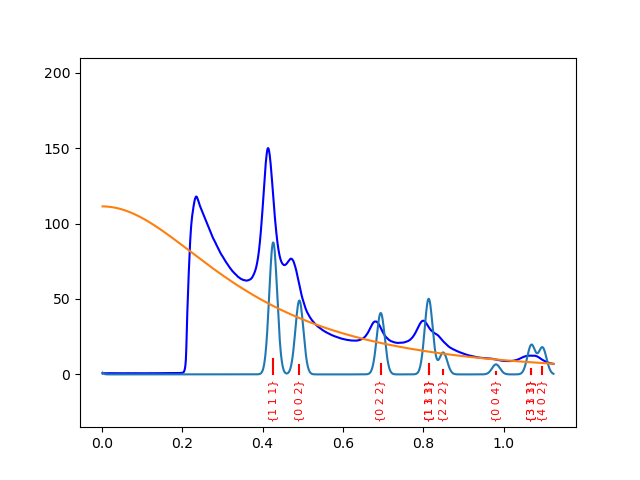

In [47]:
# -------Input of grain size ----
resolution  = 0 # 1/nm
thickness = 100 # Ang
# -------------------------------

from scipy import signal

width = (1/thickness + resolution) / scale
scale = ft.get_slope(main_dataset.dim_0.values)  *1.085*1.0/10

intensity2 = intensity/intensity.max()*10

gauss = signal.gaussian(len(profile), std=width)
simulated_profile = np.zeros(len(profile))
rec_dist = np.linspace(1,len(profile),len(profile))*scale

x  =[]
yAu = []
yC  = []
for i in rec_dist:
    yAu.append(ks.feq('Au', i))
    yC.append(ks.feq('C', i))
        
plt.figure()
plt.plot(rec_dist,profile/profile.max()*150, color='blue', label='experiment');
for j in range(len(unique)-1):
    if unique[j] < len(profile)*scale:
        # plot lines
        plt.plot([unique[j],unique[j]], [0, intensity2[j]],c='r')
        # plot indices
        index = '{'+f'{family[j][0]:.0f} {family[j][1]:.0f} {family[j][2]:.0f}'+'}' # pretty index string
        plt.text(unique[j],-3, index, horizontalalignment='center',
              verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'red')
        
        # place Gaussian with appropriate width in profile
        g = np.roll(gauss,int(-len(profile)/2+unique[j]/scale))* intensity2[j]*np.array(yAu)*1.3#rec_dist**2*10
        simulated_profile = simulated_profile + g
plt.plot(np.linspace(1,len(profile),len(profile))*scale,simulated_profile, label='simulated');
plt.plot(rec_dist,np.array(yAu)**2, label='form_factor')

plt.ylim(-35,210);

## Publication Quality Output

Now we have all the ingredients to make a publication quality plot of the data.

<IPython.core.display.Javascript object>


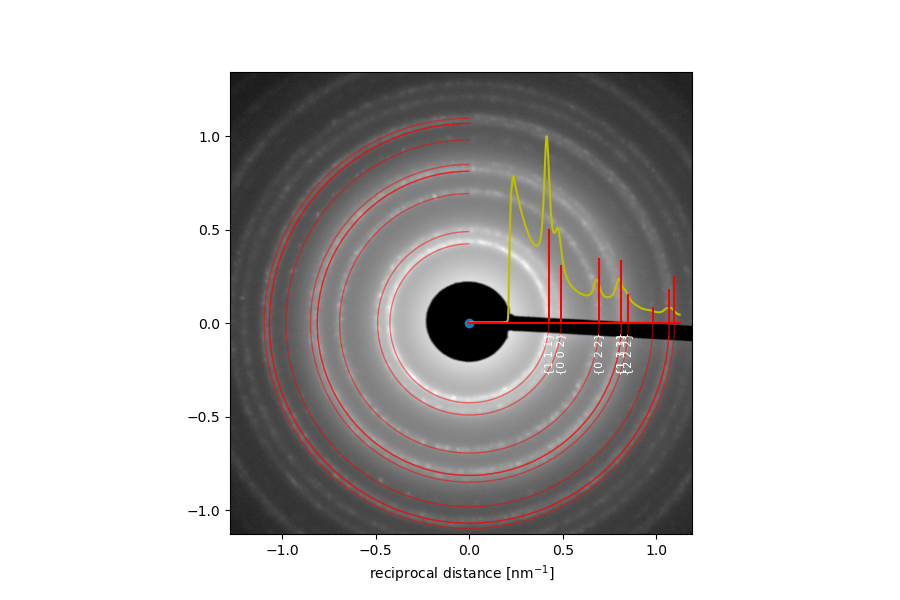

In [50]:
from matplotlib import patches
fig = plt.figure(figsize=(9, 6)) 

extent= np.array([-center[0], diff_pattern.shape[0]-center[0],-diff_pattern.shape[1]+center[1], center[1]])*scale

plt.imshow(np.log2(1+diff_pattern).T,cmap='gray', extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')
ax = fig.gca()
#ax.add_artist(circle1);
plt.plot(np.linspace(1,len(profile),len(profile))*scale,profile/profile.max(), color='y');
plt.plot((0,len(profile)*scale),(0,0),c='r')

for j in range(len(unique)-1):
    i = indices[j]   
    if distances[i] < len(profile)*scale:
        plt.plot([distances[i],distances[i]], [0, intensity2[j]/20],c='r')
        arc = patches.Arc((0,0), distances[i]*2, distances[i]*2, angle=90.0, theta1=0.0, theta2=270.0, color='r', fill= False, alpha = 0.5)#, **kwargs)
        ax.add_artist(arc);
plt.scatter(0,0);

for i in range(6):
    index = '{'+f'{family[i][0]:.0f} {family[i][1]:.0f} {family[i][2]:.0f}'+'}' # pretty index string
    plt.text(unique[i],-0.05, index, horizontalalignment='center',
             verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

### Quiz

What would the figure caption for above figure be?

### What does the above figure convey?
* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?

### What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattce parameter better than 1% if we use high scattering angles!

## Logging the results

In [46]:
out_tags['analysis'] = 'Indexing_Diffraction_Rings'
out_tags['scale'] = scale
log_group = ft.log_results(main_dataset, dataset=None, attributes=out_tags)

current_filename = log_group.file.filename
ft.h5_tree(main_dataset)
main_dataset.h5_dataset.file.close()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ GOLD_NP_DIFF
      ------------
      ├ GOLD_NP_DIFF
      ├ __dict__
        --------
      ├ _axes
        -----
      ├ _original_metadata
        ------------------
      ├ original_metadata
        -----------------
      ├ u
      ├ v
    ├ Log_000
      -------
      ├ analysis
      ├ center
      ├ polar_projection
      ├ radial_average
      ├ reflections-0-index
      ├ reflections-0-intensity
      ├ reflections-0-multiplicity
      ├ reflections-0-recip_distances
      ├ reflections-0-structure_factor
      ├ reflections-1-index
      ├ reflections-1-intensity
      ├ reflections-1-multiplicity
      ├ reflections-1-recip_distances
      ├ reflections-1-structure_factor
      ├ reflections-10-index
      ├ reflections-10-intensity
      ├ reflections-10-multiplicity
      ├ reflections-10-recip_distances
      ├ reflections-10-structure_factor
      ├ reflections-11-index
      ├ reflections-11-in

## Conclusion

We only need the scatterng factors to calculate the ring pattern.

A comparison between simulation and experiment can be very precise.

Normally one would do a fit of the most prominent peaks to establish the scale.

## Navigation
- <font size = "3">  **Back: [Structure Factors](CH2_04-Basic_Crystallography.ipynb)** </font>
- <font size = "3">  **Next: [Scttering Geometry](CH2_06-Kinematic_Scattering_Geometry.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>

## Appendix

Opening the hdf5 file and plot the data again

### Open hf5 file

In [51]:
new_dataset = ft.open_file(current_filename)

NameError: name 'current_filename' is not defined

### And Plot

Because we saved all the results in all steps, it is straight forward to retrieve the publication quality plot again.

In [52]:
## Access the data of the loaded image


diff_pattern = np.array(new_dataset)
diff_pattern = diff_pattern-diff_pattern.min()
current_channel = new_dataset.h5_dataset.parent.parent
result_group = current_channel['Log_000']

center = result_group['center'][()]
scale = result_group['scale'][()]

from matplotlib import patches
fig = plt.figure(figsize=(9, 6)) 
ax = plt.gca()
extent= np.array([-center[0], diff_pattern.shape[0]-center[0],-diff_pattern.shape[1]+center[1], center[1]])*scale

plt.imshow(np.log2(1+diff_pattern).T, cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.xlabel(r'reciprocal distance [nm$^{-1}$]')

profile = result_group['radial_average'][()]
plt.plot(np.linspace(1,len(profile),len(profile))*scale,profile/profile.max()*10, color='y');#
plt.plot((0,len(profile)*scale),(0,0),c='r')
reflections = {}
for key in result_group:
    if 'reflection' in key:
        keys = key.split('-')
        
        if keys[1] not in reflections:
            reflections[keys[1]]={}
        reflections[keys[1]][keys[2]] =  result_group[key][()]
        #print( reflections[keys[1]][keys[2]] )
for key in reflections:
    distance = reflections[key]['recip_distances']
    if distance < len(profile)*scale:
        
        plt.plot([distance,distance], [0, reflections[key]['intensity']/1000],c='r')
        arc = patches.Arc((0,0), distance*2, distance*2, angle=90.0, theta1=0.0, theta2=270.0, color='r', fill= False, alpha = 0.5)#, **kwargs)
        ax.add_artist(arc);
plt.scatter(0,0);
for i in range(7):
    index = reflections[str(i)]['index'] # pretty index string
    plt.text(unique[i],-0.5, index, horizontalalignment='center',
          verticalalignment='top', rotation = 'vertical', fontsize=8, color = 'white')

NameError: name 'new_dataset' is not defined

### 3D Plot of Miller Indices

<IPython.core.display.Javascript object>


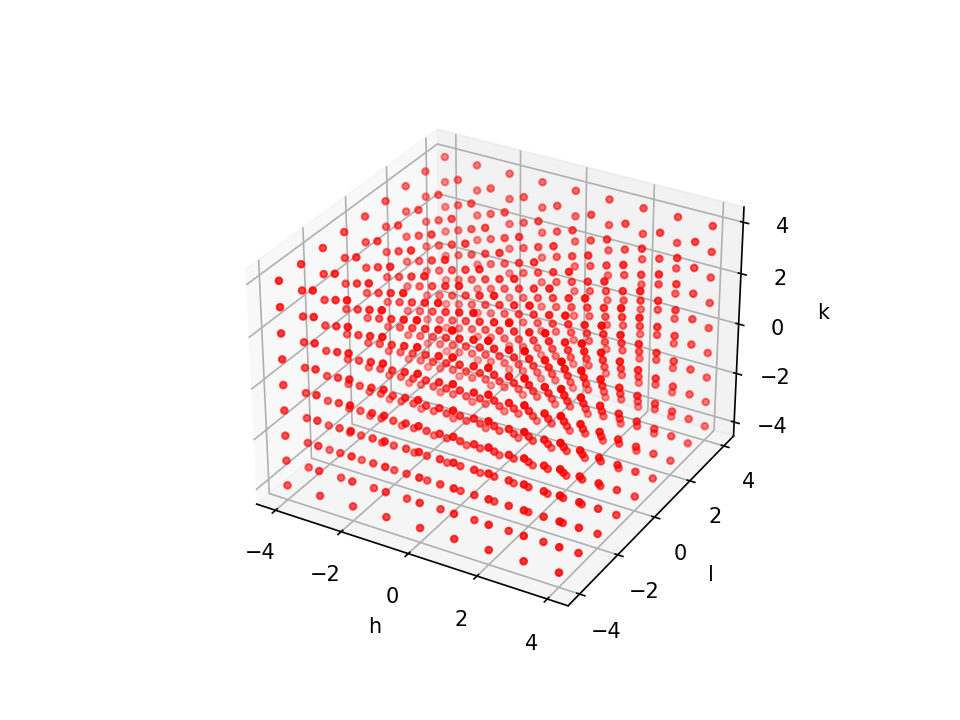

Text(0.5, 0, 'k')

In [7]:
hkl_max = 4
h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)  # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h,h,h) )) # all evaluated Miller indices

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hkl[:,0], hkl[:,2], hkl[:,1], c='red', s=10)
plt.xlabel('h')
plt.ylabel('l')
fig.gca().set_zlabel('k')
#ax.set_aspect('equal')

## Reciprocal Space and Miller Indices

For a reciprocal cubic  unit cell with lattice parameter $b = \frac{1}{a}$:

$$	
\vec{g}_{hkl} = \begin{pmatrix}h\\k\\l\end{pmatrix}  \cdot	\begin{pmatrix}b&0&0\\0&b&0\\0&0&b\end{pmatrix} 
$$			

Or more general
			
$$			
\vec{g}_{hkl} = \begin{pmatrix}h\\k\\l\end{pmatrix} \cdot 	\begin{pmatrix}b_{1,1}&b_{1,2}&b_{1,3}\\b_{2,1}&b_{2,2}&b_{2,3}\\b_{3,1}&b_{3,2}&b_{3,3}\end{pmatrix} 
$$


The matrix is of course the reciprocal unit cell or the inverse of the structure matrix.

Therefore, we get any reciprocal lattice vector with the dot product of its Miller indices and the reciprocal lattice matrix.




Spacing of planes with Miller Indices $hkl$
$$			\begin{align*}
			|\vec{g}_{hkl}|& = \frac{1}{d}\\
			d &= \frac{1}{|\vec{g}_{hkl}|}
			\end{align*}$$
			
The length of a vector is called its **norm**.


Be careful there are two different notations for the reciprocal lattice vectors:
- materials science 
- physics

The notations are different in a factor $2\pi$.  The introduction of  $2\pi$ in physics allows to take care of the $n$ more naturally.

In the materials science notation the reciprocal lattice points are directly associated with the Bragg reflections in your diffraction pattern. <br>
(OK,s we are too lacy to keep track of $2\pi$)

### All Possible Reflections

Are then given by the all permutations of the Miller indices and the reiprocal unit cell matrix.

All considered Miller indices are then produced with the itertool package of python.


Evaluation of (6859, 3) reflections of (6859, 3) Miller indices


<IPython.core.display.Javascript object>


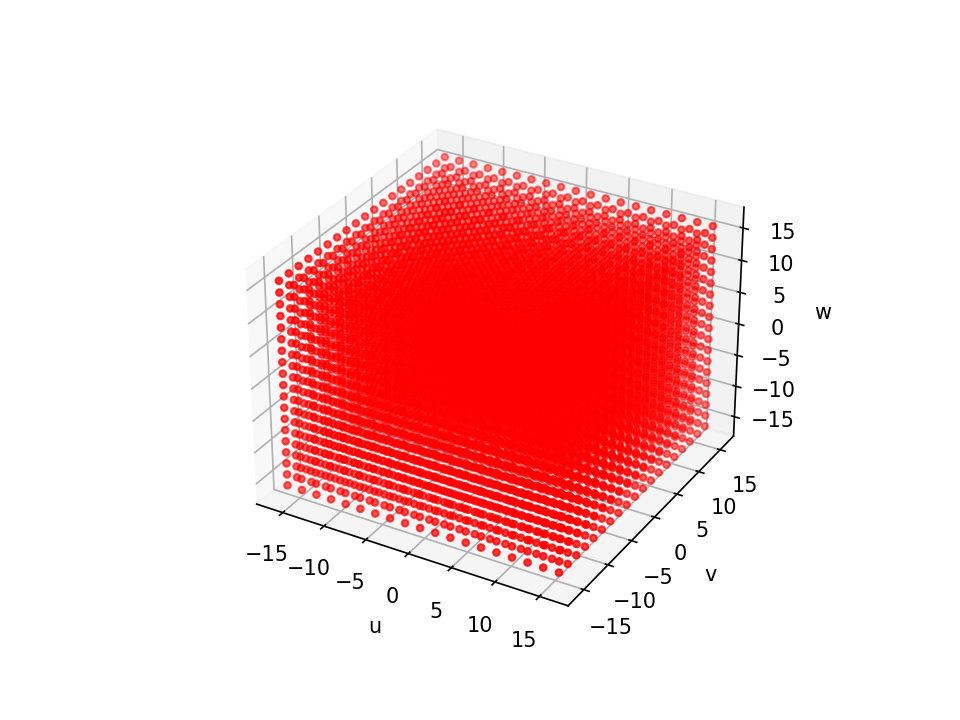

Text(0.5, 0, 'w')

In [10]:

hkl_max = 9#  maximum allowed Miller index

h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h,h,h) )) # all evaluated Miller indices
g_hkl = np.dot(hkl,reciprocal_unit_cell)         # all evaluated reciprocal lattice points

print(f'Evaluation of {g_hkl.shape} reflections of {hkl.shape} Miller indices')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_hkl[:,0], g_hkl[:,2], g_hkl[:,1], c='red', s=10)
plt.xlabel('u')
plt.ylabel('v')
fig.gca().set_zlabel('w')


### Atomic form factor

If we look at the scattering power of a single atom that deflects an electron:
    
![Single atom scattering](images/scattering_single_atom.jpg)

See [Atomic Form Factor](CH2_02-Atomic_Form_Factor.ipynb) for details

## Calculate Structure Factors 

To extend the single atom view of the atomic form factor $f(\theta$)  to a crystal, we change to the structure factor $F(\theta)$. The structure factor  $F(\theta)$ is a measure
of the amplitude scattered by a unit cell of a crystal
structure. 

Because $F(\theta)$ is an amplitude like  $f(\theta)$, it also
has dimensions of length.We can define  $F(\theta)$ as: 
$$ F_{hkl}(\theta) = \sum_{j=1}^{\inf} f_i(\theta) \mathrm{e}^{[-2 \pi i (h x_j+k y_j + l z_j)]} 
$$

The sum is over all the $i$ atoms in the unit cell (with
atomic coordinates $x_i, y_i, z_i$ 

The structure factors $f_i(\theta)$ are multiplied by a phase factor (the exponential function).
The phase factor takes account of the difference in phase
between waves scattered from atoms on different but
parallel atomic planes with the same Miller indices$ (hkl)$.

The scattering angle $\theta$  is the angle between the angle between the incident
and scattered electron beams.


Please identify all the variables in line 10 below. Please note that we only do a finite number of hkl

In [8]:
# Calculate Structure Factors

structure_factors = []

base = np.dot(tags['base'],tags['unit_cell'])  # transformation from relative to Carthesian coordinates
for j  in range(len(g_hkl)):
    F = 0
    for b in range(len(base)):
        f = ks.feq(tags['elements'][b],np.linalg.norm(np.dot(g_hkl[j], reciprocal_lattice))) # Atomic form factor for element and momentum change (g vector)
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*base[b]).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)


### All Allowed Reflections

The structure factor determines whether a reflection is allowed or not.

If the structure factor is zero, the reflection is called forbidden.

In [9]:
# Allowed reflections have a non zero structure factor F (with a  bit of numerical error)
allowed = np.absolute(structure_factors) > 0.001

print(f' Of the evaluated {hkl.shape[0]} Miller indices {allowed.sum()} are allowed. ')

distances = np.linalg.norm(g_hkl, axis = 1)
# We select now all the 
zero = distances == 0.
allowed = np.logical_and(allowed,np.logical_not(zero))

F = F[allowed]
g_hkl = g_hkl[allowed]
hkl = hkl[allowed]
distances = distances[allowed]


 Of the evaluated 6859 Miller indices 1365 are allowed. 


### Families of reflections

reflections with the same length of reciprocal lattice vector are called families

In [10]:
sorted_allowed = np.argsort(distances)

distances = distances[sorted_allowed]
hkl = hkl[sorted_allowed]
F = F[sorted_allowed]

# How many have unique distances and what is their muliplicity

unique, indices  = np.unique(distances, return_index=True)

print(f' Of the {allowed.sum()} allowed Bragg reflections there are {len(unique)} families of reflections.')


 Of the 1364 allowed Bragg reflections there are 47 families of reflections.


### Intensities and Multiplicities


In [11]:
multiplicitity = np.roll(indices,-1)-indices
intensity = np.absolute(F[indices]**2*multiplicitity)
print('\n index \t     hkl \t 1/d [1/nm]     d [pm] \t  F \t multip. intensity' )
family = []
for j in range(len(unique)-1):
    i = indices[j]    
    i2 = indices[j+1]   
    family.append(hkl[i+np.argmax(hkl[i:i2].sum(axis=1))])
    print(f'{i:3g}\t {family[j]} \t  {distances[i]:.2f}  \t {1/distances[i]*1000:.0f} \t {np.absolute(F[i]):.2f}, \t  {indices[j+1]-indices[j]:3g} \t {intensity[j]:.2f}') 
    



 index 	     hkl 	 1/d [1/nm]     d [pm] 	  F 	 multip. intensity
  0	 [1. 1. 1.] 	  3.06  	 327 	 10.05, 	    8 	 808.52
  8	 [0. 2. 2.] 	  4.99  	 200 	 7.10, 	   12 	 605.58
 20	 [3. 1. 1.] 	  5.85  	 171 	 4.02, 	   24 	 387.33
 44	 [0. 0. 4.] 	  7.06  	 142 	 4.39, 	    6 	 115.65
 50	 [3. 1. 3.] 	  7.69  	 130 	 2.75, 	   24 	 182.13
 74	 [2. 2. 4.] 	  8.64  	 116 	 3.30, 	   24 	 260.59
 98	 [1. 5. 1.] 	  9.17  	 109 	 2.14, 	   24 	 109.40
122	 [3. 3. 3.] 	  9.17  	 109 	 2.14, 	    8 	 36.47
130	 [0. 4. 4.] 	  9.98  	 100 	 2.65, 	   12 	 84.35
142	 [3. 5. 1.] 	  10.44  	 96 	 1.75, 	   48 	 146.49
190	 [0. 2. 6.] 	  11.16  	 90 	 2.22, 	   24 	 118.13
214	 [3. 5. 3.] 	  11.57  	 86 	 1.48, 	   24 	 52.43
238	 [4. 4. 4.] 	  12.22  	 82 	 1.91, 	    8 	 29.07
246	 [5. 5. 1.] 	  12.60  	 79 	 1.28, 	   48 	 78.66
294	 [6. 2. 4.] 	  13.20  	 76 	 1.67, 	   48 	 133.86
342	 [5. 5. 3.] 	  13.55  	 74 	 1.13, 	   72 	 91.64
414	 [0. 8. 0.] 	  14.11  	 71 	 1.48, 	    6 	 13.23
420	

## Allowed reflections for Silicon:   
$\ \ |F_{hkl}|^2 =  \begin{cases} (  h , k , l \ \ \mbox{ all odd} &\\
                    (  h ,| k , l \ \  \mbox{all even}& \mbox{and}\ \ h+k+l = 4n\end{cases}$ 

Check above allowed reflections whether this condition is met for the zero order Laue zone.


Please note that the forbidden and alowed reflections are directly a property of the structure factor.

## Diffraction with Parallel Illumination 

Polycrystalline Sample  |Single Crystalline Sample
:---------:|:-----------------:
ring pattern |spot pattern
depends on $F(\theta)$ | depends on $F(\theta)$ 
		| depends on excitation error $s$

## Ring Pattern
<img src="images/CL375.jpg" alt="Bragg's Law" width="300" >
<img src="images/ProfileOfCL375.jpg" alt="Bragg's Law" width="300" >

**Ring Pattern:**
- The profile of a ring diffraction pattern (of a polycrystalline sample) is very close to what a you are used from X-ray diffraction.
- The x-axis is directly the magnitude of the $|\vec{g}| = 1/d$ of a hkl plane set.
	
- The intensity of a Bragg reflection is directly related to the square of the structure factor $I = F^2(\theta)$
	
- The intensity of a ring is directly related to the multiplicity of the family of planes. 


**Ring Pattern Problem:**
-  Where is the center of the ring pattern
- Integration over all angles (spherical coordinates)
- Indexing of pattern is analog to x-ray diffraction. 

The Ring Diffraction Pattern are completely defined by the Structure Factor

<IPython.core.display.Javascript object>


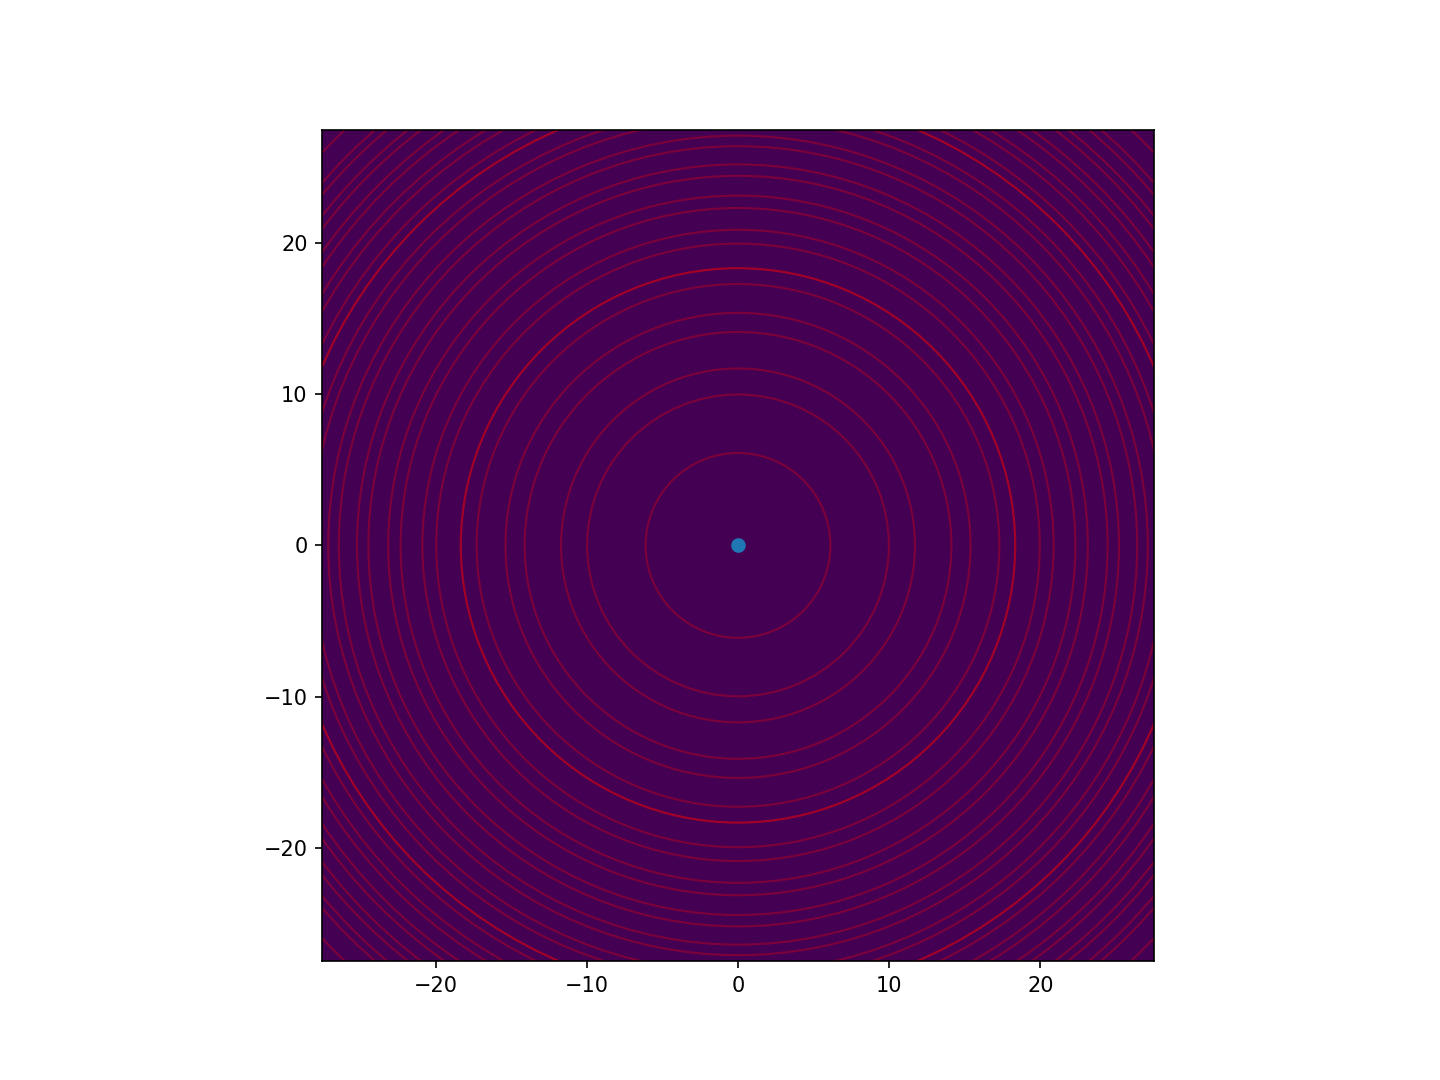

In [12]:
from matplotlib import patches
fig, ax = plt.subplots()
plt.scatter(0,0);
img = np.zeros((1024,1024))
extent = np.array([-1,1,-1,1])*np.max(unique)
plt.imshow(img, extent = extent)

for radius in unique:   
    circle = patches.Circle((0,0), radius*2, color='r', fill= False, alpha = 0.3)#, **kwargs)
    ax.add_artist(circle);


## Conclusion
The scattering geometry provides all the tools to determine which reciprocal lattice points are possible and which of them are allowed.

Next we need to transfer out knowledge into a  diffraction pattern.

## Navigation

- <font size = "3">  **Back Chapter 1: [Basic Crystallography](CH2_03-Basic_Crystallography.ipynb)** </font>
- <font size = "3">  **Next: [Analyzing Ring Diffraction Pattern](CH2_05-Diffraction_Rings.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-_Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>

